In [1]:
import numpy as np
import pandas as pd
from astropy.time import Time

from mpcq.client import MPCObservationsClient
from mpcq.utils import observations_to_dataframe, submissions_to_dataframe

client = MPCObservationsClient.connect_using_gcloud()

This notebook requires find_orb to be installed. By default, find_orb will install its executables inside of ~/bin. 

See this [Dockerfile](https://github.com/Bill-Gray/find_orb/blob/master/Dockerfile) for instructions on how to install find_orb. 

In [2]:
object_id = "2013 RR165"

# Query for this object's observations and its submission history
# We will use the submission history to determine the order in which
# observations for this object were found and submitted to the MPC
observations = client.get_object_observations(object_id)
submissions = client.get_object_submissions(object_id)

observations = observations_to_dataframe(list(observations))
observations.sort_values(by="timestamp", inplace=True, ignore_index=True)

submissions = submissions_to_dataframe(list(submissions))
submissions.sort_values(by="timestamp", inplace=True, ignore_index=True)

In [3]:
import subprocess
import os
import tempfile
import json
import shutil

from adam_core.orbits import Orbits
from adam_core.coordinates import CartesianCoordinates, CoordinateCovariances, Origin
from adam_core.time import Timestamp

def observations_to_ades(observations, file_out) -> str:
    """
    Writes observations to a reduced MPC ADES file that can be 
    used with find_orb. 

    """
    ades = observations.rename(columns={
        "unpacked_provisional_designation": "provID",
        "timestamp": "obsTime",
        "ra_rms": "rmsRA",
        "dec_rms": "rmsDec",
        "mag_rms": "rmsMag",
        "filter_band": "band",
        "obscode": "stn",
    })

    column_order = ["provID", "obsTime", "ra", "dec", "mag", "rmsRA", "rmsDec", "rmsMag", "band", "stn"]
    ades = ades[column_order]

    observation_times = Time(
        ades["obsTime"].values,
        format="datetime64",
        scale="utc",
        precision=3,
    )
    ades["obsTime"] = np.array([i + "Z" for i in observation_times.utc.isot])

    # Note not necessarily true for all observations but find_orb will
    # not use this information regardless
    ades["astCat"] = np.full(len(ades), "Gaia2")
    ades["mode"] = np.full(len(ades), "CCD")

    col_header = "|".join(ades.columns) + "\n"

    with open(file_out, "w") as f:
        f.write("# version=2017\n")
        f.write(col_header)

    return ades.to_csv(file_out, index=False, header=False, sep="|", mode="a")

def run_find_orb(observations, out_dir=None):
    """
    Runs find_orb on the given observations and returns the calculated
    orbit and covariance matrix. 

    """
    assert observations["unpacked_provisional_designation"].nunique() == 1

    my_env = os.environ.copy()
    my_env["PATH"] = f"{os.path.expanduser('~/bin')}:{my_env['PATH']}"

    with tempfile.TemporaryDirectory() as tempdir:
        ades_file = os.path.join(tempdir, "ades.psv")
        observations_to_ades(observations, ades_file)


        output = subprocess.run(
            ["fo", ades_file, "-O", tempdir, f"-tEjd{Time(observations['timestamp'].max(), scale='utc').utc.jd}", "-j"],
            capture_output=True,
            text=True,
            env=my_env,
        )

        if output.returncode != 0:
            raise RuntimeError(f"find_orb failed: {output.stderr}")
        
        with open(os.path.join(tempdir, "covar.json")) as f:
            result = json.load(f)
            
            state = np.array(result["state_vect"])
            covariance_matrix = np.array(result["covar"]).reshape(1, 6, 6)
            coords = CartesianCoordinates.from_kwargs(
                time=Timestamp.from_jd([result["epoch"]], scale="tt"),
                x=state[0:1],
                y=state[1:2],
                z=state[2:3],
                vx=state[3:4],
                vy=state[4:5],
                vz=state[5:],
                covariance=CoordinateCovariances.from_matrix(covariance_matrix),
                origin=Origin.from_kwargs(code=["SUN"]),
                frame="ecliptic",
            )

        if out_dir is not None:
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            shutil.copytree(tempdir, out_dir)
            shutil.copy(ades_file, out_dir)
        
    return Orbits.from_kwargs(
        object_id=observations["unpacked_provisional_designation"].values[:1], 
        coordinates=coords
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
import quivr as qv

def run_object_observations_by_submission(observations, submissions):
    """
    Runs find_orb on the observations for a given object, grouped by
    submission. 

    """

    fitted_orbits = []
    submission_ids = []
    unique_submission_ids = submissions["id"].unique()
    for submission_id in unique_submission_ids:
        submission_ids.append(submission_id)
        observations_subset = observations[observations["submission_id"].isin(submission_ids)]
        fitted_orbits.append(run_find_orb(observations_subset))

    return qv.concatenate(fitted_orbits)

orbit = run_object_observations_by_submission(observations, submissions)

Text(0.5, 0, 'Submission Time')

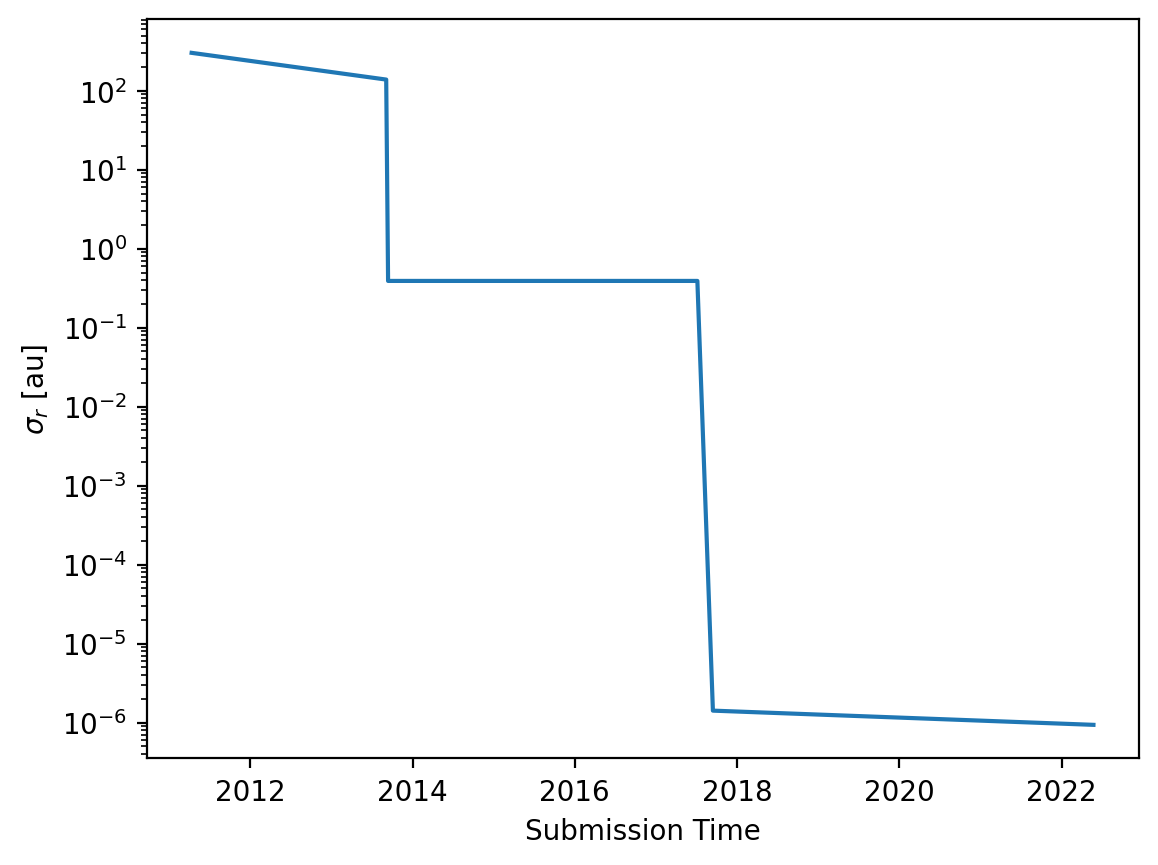

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, dpi=200)
ax.plot(submissions["timestamp"], orbit.coordinates.sigma_r_mag)
ax.set_yscale("log")
ax.set_ylabel(r"$\sigma_r$ [au]")
ax.set_xlabel("Submission Time")